### Important Questions:
1. What is the optimal error?
2. What is the human level error?
3. How much better or worse is the model compared to human level error?

My assumption is that optimal error is zero %, and human level error is close to that. 
But it is likely that the human level error is considerably worse.

In [2]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW, lr_scheduler as LRScheduler

from transformers import get_scheduler

from jre_utils.datapath import model_ready_data_paths, model_output_data_paths
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.metrics import MSELossWeighted
from jre_utils.process import get_cumulative_growth
from jre_utils.visualize import plot_time_series
from jre_utils.engine import (
    evaluate,
    train,
    evaluate_weighted,
    train_weighted,
    EarlyStopper,
)


warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [3]:
metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
    "weighted_mean_smoothed": "unit_price_wmean_smoothed",
    "weighted_median_smoothed": "unit_price_wmedian_smoothed",
    "mean_smoothed": "unit_price_mean_smoothed",
    "median_smoothed": "unit_price_median_smoothed",
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric_key = "weighted_median_smoothed"
metric = metrics[metric_key]
metric_pct_chg = metric + "_pct_chg"
upcoming_metric = "upcoming_" + metric
normalized_metric_pct_chg = "normalized_" + metric + "_pct_chg"

In [4]:
start_year = 2006
eval_start_year = 2020 # eval_years = [2020, 2021, 2022]
eval_end_year = 2022

dataset_key = "transactions"
years_ahead = 2
dataset_name = f"sequence_{dataset_key}_{metric_key}_{years_ahead}"
output_dataset_name = f"{dataset_name}_{eval_start_year}"
model_ready_data_path = model_ready_data_paths[dataset_name]
model_output_data_path = model_output_data_paths[output_dataset_name]

df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= eval_end_year]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)

df[normalized_metric_pct_chg] = df.groupby("year")[
    metric_pct_chg
].transform(lambda x: (x - x.mean()) / x.std())

train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
eval_df = df[df["year"] >= eval_start_year]

In [5]:
train_df[train_df["area_code"] == 13101][["year", metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_wmedian_smoothed,unit_price_wmedian_smoothed_pct_chg,normalized_unit_price_wmedian_smoothed_pct_chg
41,2007,3.190579e+06,0.121657,0.231639
183,2008,3.144827e+06,0.055103,0.192289
998,2009,2.910509e+06,-0.087780,-0.081778
1816,2010,2.697234e+06,-0.142327,-0.223541
3505,2011,2.354779e+06,-0.190939,-0.544477
5414,2012,2.224987e+06,-0.175086,-0.617449
6840,2013,2.791684e+06,0.185540,0.825369
8819,2014,3.167834e+06,0.423754,1.790829
9928,2015,3.297759e+06,0.181280,0.722313
11336,2016,3.560900e+06,0.124081,0.415789


In [6]:
eval_df[eval_df["area_code"] == 13101][["year", metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_wmedian_smoothed,unit_price_wmedian_smoothed_pct_chg,normalized_unit_price_wmedian_smoothed_pct_chg
16795,2020,4.106235e+06,0.065080,0.197436
18265,2021,4.260203e+06,0.070969,0.103763
20002,2022,5.212293e+06,0.269361,0.624575


In [10]:
idx = 20002
row = df.iloc[idx]
target = row[normalized_metric_pct_chg]
area_code, year = row["area_code"], row["year"]
window = (
    df[
        (df["area_code"] == area_code)
        & (df["year"] <= year - 2)
    ]
    .sort_values(by="year")
    .tail(5)
)


In [11]:
window

,unit_price_wmedian_smoothed_pct_chg,unit_price_wmedian_smoothed,year,years_since_crisis,count,total_traded_area,population,taxpayer_count,taxable_income,taxable_income_per_taxpayer,taxable_income_growth,taxable_income_per_taxpayer_growth,total_tax,total_tax_growth,new_dwellings,existing_dwellings,net_migration_ratio,new_dwellings_ratio,migrations_is_available,taxable_income_is_available,dwellings_is_available,total_tax_is_available,area_code,area,normalized_unit_price_wmedian_smoothed_pct_chg
11336,0.124081,3.560900e+06,2016,8,64.0,10530.0,60870.0,34324.0,314359478.0,9158.591015,0.123044,0.079495,18441614.0,0.057706,1545.0,38740.0,0.014473,0.039881,1,1,1,1,13101,Tokyo-to Chiyoda-ku,0.415789
12970,0.119927,3.693249e+06,2017,9,66.0,11530.0,61751.0,35326.0,333664476.0,9445.294571,0.061411,0.031304,19084096.0,0.034839,1415.0,40285.0,0.017522,0.035125,1,1,1,1,13101,Tokyo-to Chiyoda-ku,0.371442
14188,0.082684,3.855331e+06,2018,10,66.0,11580.0,62833.0,36299.0,362690825.0,9991.758037,0.086993,0.057856,19816187.0,0.038361,978.0,41700.0,0.032212,0.023453,1,1,1,1,13101,Tokyo-to Chiyoda-ku,0.256304
15092,0.077072,3.977897e+06,2019,0,64.0,10995.0,64857.0,38175.0,412894018.0,10815.822344,0.138419,0.082474,21648748.0,0.092478,787.0,42487.0,0.028108,0.018523,1,1,1,1,13101,Tokyo-to Chiyoda-ku,0.299460
16795,0.065080,4.106235e+06,2020,1,41.0,5665.0,66680.0,39873.0,400984266.0,10056.536152,-0.028845,-0.070201,20573851.0,-0.049652,1159.0,43646.0,0.014607,0.026555,1,1,1,1,13101,Tokyo-to Chiyoda-ku,0.197436


In [12]:
target

0.6245749840790618

In [13]:
columns = [
    metric,
    metric_pct_chg,
    "count",
    "total_traded_area",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "new_dwellings",
    "existing_dwellings",
    "new_dwellings_ratio",
    "net_migration_ratio",
    "total_tax",
    "total_tax_growth",
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
]
columns_normalized = [f"{col}_normalized" for col in columns]

train_df_mean = train_df[columns].mean()
train_df_std = train_df[columns].std()
train_df[columns_normalized] = (train_df[columns] - train_df_mean) / train_df_std
eval_df[columns_normalized] = (eval_df[columns] - train_df_mean) / train_df_std

count_scale_factor = 3
count_max = train_df["count"].max()
train_df["count_scaled"] = 1 + (train_df["count"] / count_max) * 3
eval_df["count_scaled"] = 1 + (eval_df["count"] / count_max) * 3

df = pd.concat([train_df, eval_df])

# more detailed area level normalization would help

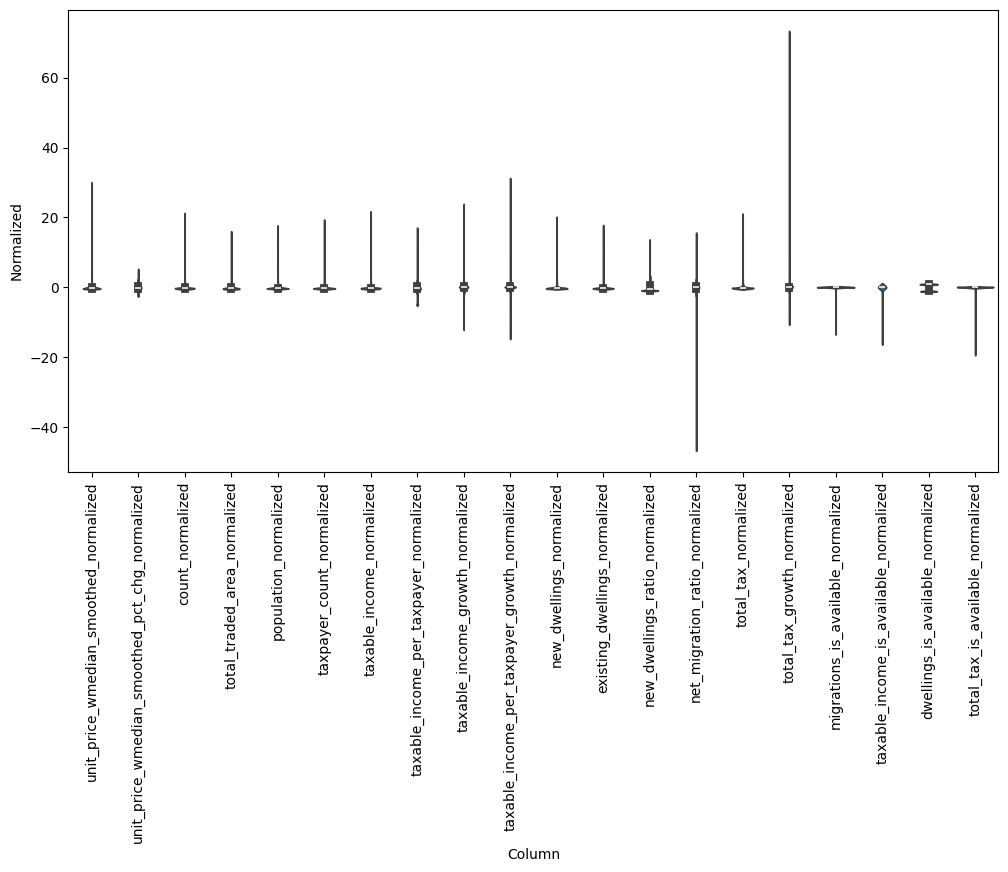

In [14]:
df_std = df[columns_normalized].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df[columns_normalized].keys(), rotation=90)

In [15]:
# Will yearly normalized columns be better?
# If average net migration higher for factor area X over area Y in the same year, I would think it would have higher return
# Compared to normalizing over all years. That also gives us access to future years which is undesirable

columns_normalized_yearly = [f"{col}_normalized_yearly" for col in columns]
for col in columns:
    df[f"{col}_normalized_yearly"] = df.groupby("year")[col].transform(
        lambda x: (x - x.mean()) / x.std()
    )

# To account for years where the data is not available and all the values are zero. In those situations, the normalized values will be NaN.
df = df.fillna(0)

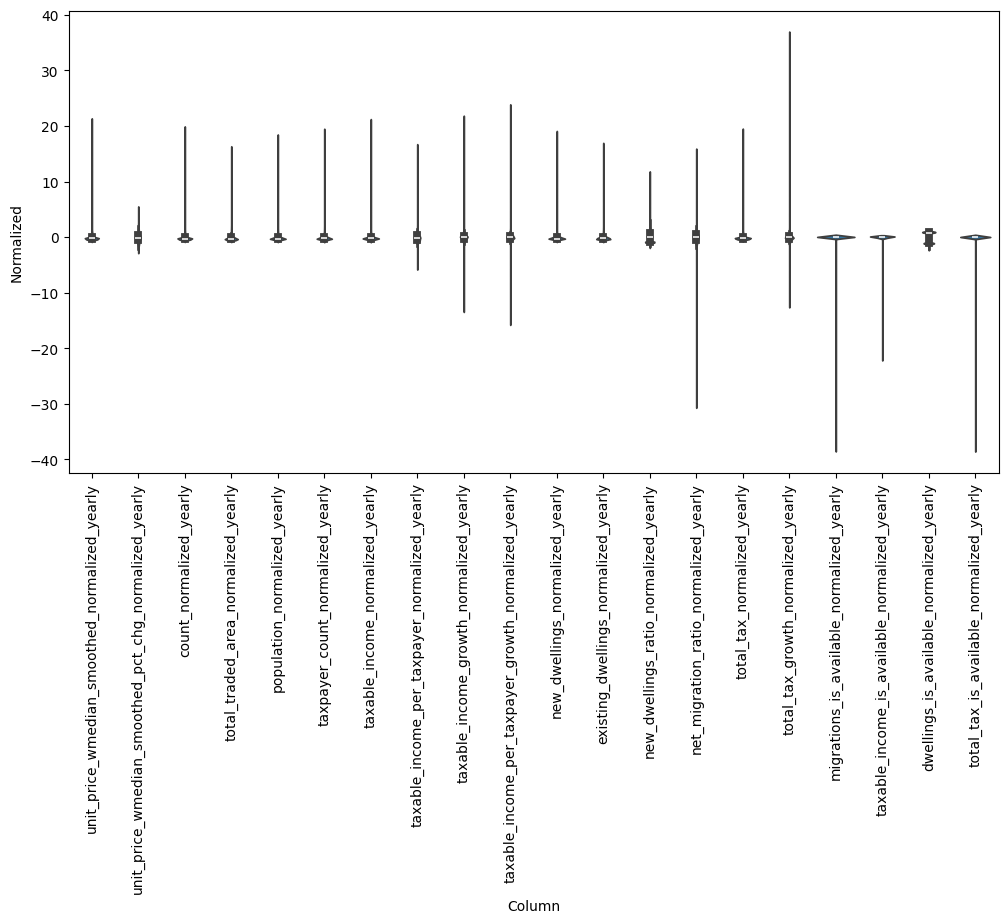

In [16]:
df_std = df[columns_normalized_yearly].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df[columns_normalized_yearly].keys(), rotation=90)

In [17]:
feature_columns = [metric_pct_chg] + columns_normalized_yearly + ["migrations_is_available", "taxable_income_is_available", "dwellings_is_available"]

time_series_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    feature_columns=feature_columns,
    shift=years_ahead
)

time_series_dataset_transformed = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    shift=years_ahead
)

for i, sampleX in enumerate(time_series_dataset):
    print(
        i,
        sampleX["window"].shape,
        sampleX["target"].shape,
        sampleX["target"].values,
        sampleX["weight"].values,
    )
    if i == 3:
        break


for i, sampleY in enumerate(time_series_dataset_transformed):
    print(
        i,
        sampleY["window"].shape,
        sampleY["target"].shape,
        sampleY["target"],
        sampleY["weight"],
    )
    if i == 3:
        break

0 (0, 24) (1,) [-0.22623718] [1.49033644]
1 (0, 24) (1,) [-0.44631858] [2.45311382]
2 (0, 24) (1,) [1.16197697] [1.0765927]
3 (0, 24) (1,) [-2.61665333] [1.05153901]
0 torch.Size([5, 24]) torch.Size([1]) tensor([-0.2262]) tensor([1.4903])
1 torch.Size([5, 24]) torch.Size([1]) tensor([-0.4463]) tensor([2.4531])
2 torch.Size([5, 24]) torch.Size([1]) tensor([1.1620]) tensor([1.0766])
3 torch.Size([5, 24]) torch.Size([1]) tensor([-2.6167]) tensor([1.0515])


In [18]:
BATCH_SIZE = 256

In [19]:
train_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)
eval_dataset = JapanRETimeSeriesDataset(
    df,
    eval_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20600 entries, 0 to 20599
Data columns (total 66 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   unit_price_wmedian_smoothed_pct_chg                    20600 non-null  float64
 1   unit_price_wmedian_smoothed                            20600 non-null  float64
 2   year                                                   20600 non-null  int64  
 3   years_since_crisis                                     20600 non-null  int64  
 4   count                                                  20600 non-null  float64
 5   total_traded_area                                      20600 non-null  float64
 6   population                                             20600 non-null  float64
 7   taxpayer_count                                         20600 non-null  float64
 8   taxable_income                                

### Building the Transformer Model

In [21]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [22]:
n_features = len(feature_columns)
d_model = 256
d_hid = 256
nlayers = 8
nhead = 8
dropout = 0
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    enc_dropout=enc_dropout,
    device=device,
)
model = model.to(device)


In [24]:
model.eval()

mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        
        print("Loss:", loss.item())

        break

torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.2155977487564087


In [25]:
# Write a pretraining loop to go over all datasets and pretrain on that
# Use early stopping and regularization so you don't have to worry about overfitting
# Write the required parameters and processing functions for all the datasets and put them all in a dictionary

def extract_transformer_encoder_state_dict(state_dict):
    transformer_state_dict = {}
    for key, value in state_dict.items():
        if "transformer_encoder" in key:
            transformer_state_dict[key] = value
    return transformer_state_dict

# loaded_state_dict = extract_transformer_encoder_state_dict(torch.load("../../weights/jena_climate.pt"))
# model.load_state_dict(loaded_state_dict, strict=False)


In [27]:
learning_rate = 1e-4 # 3e-4
weight_decay = 1 # 1
num_epochs = 20

In [28]:
num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = get_scheduler(
    "linear", # constant
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [29]:
# progress_bar = tqdm(range(num_training_steps))
progress_bar = None

for epoch in range(num_epochs):
    train_loss, train_r2_score = train_weighted(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)
    
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    print(f"Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

# progress_bar.close()

Epoch: 0
Train Loss: 4.0781, Eval Loss: 3.8892
Train R^2: -0.0225, Eval R^2: 0.0202
Epoch: 1
Train Loss: 3.5307, Eval Loss: 3.0022
Train R^2: 0.1128, Eval R^2: 0.2522
Epoch: 2
Train Loss: 3.3932, Eval Loss: 2.5275
Train R^2: 0.1473, Eval R^2: 0.3786
Epoch: 3
Train Loss: 3.1839, Eval Loss: 2.4996
Train R^2: 0.1994, Eval R^2: 0.3863
Epoch: 4
Train Loss: 3.0905, Eval Loss: 2.2885
Train R^2: 0.2228, Eval R^2: 0.4356
Epoch: 5
Train Loss: 2.9132, Eval Loss: 2.1843
Train R^2: 0.2674, Eval R^2: 0.4611
Epoch: 6
Train Loss: 2.7203, Eval Loss: 2.1211
Train R^2: 0.3161, Eval R^2: 0.4761
Epoch: 7
Train Loss: 2.5704, Eval Loss: 2.0974
Train R^2: 0.3539, Eval R^2: 0.4818
Epoch: 8
Train Loss: 2.4735, Eval Loss: 2.0844
Train R^2: 0.3782, Eval R^2: 0.4847
Epoch: 9
Train Loss: 2.4050, Eval Loss: 2.0720
Train R^2: 0.3955, Eval R^2: 0.4876
Epoch: 10
Train Loss: 2.3545, Eval Loss: 2.0500
Train R^2: 0.4082, Eval R^2: 0.4922
Epoch: 11
Train Loss: 2.3250, Eval Loss: 2.0286
Train R^2: 0.4156, Eval R^2: 0.4968
E

KeyboardInterrupt: 

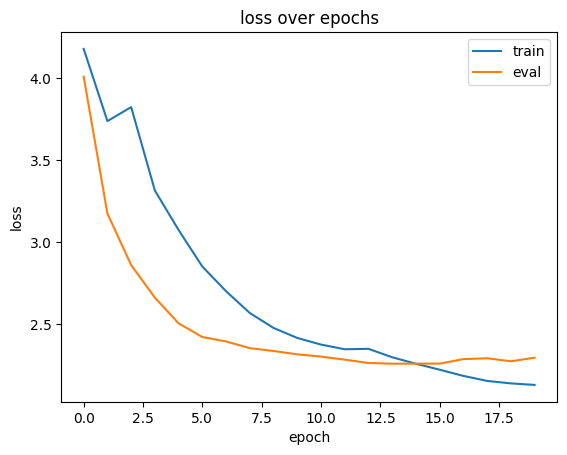

In [39]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

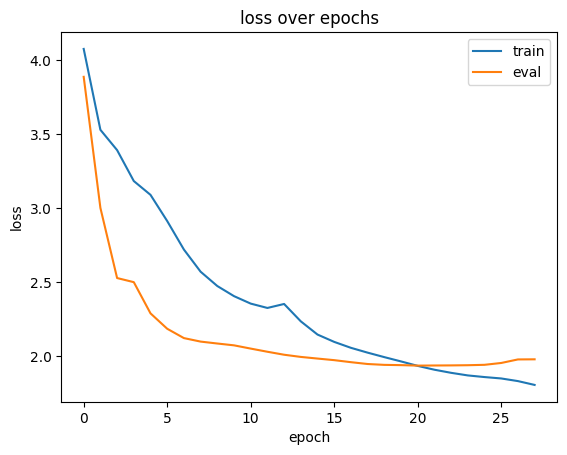

In [30]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

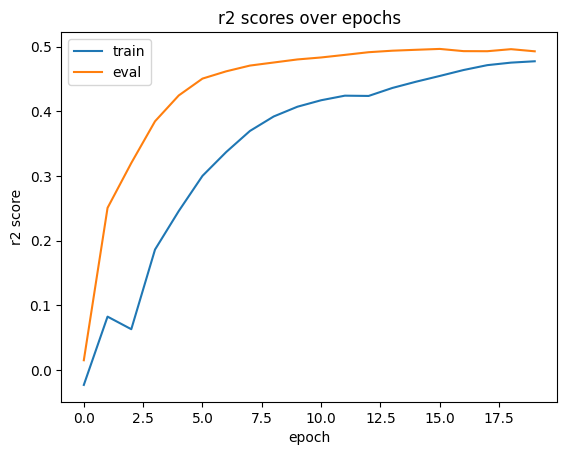

In [40]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()

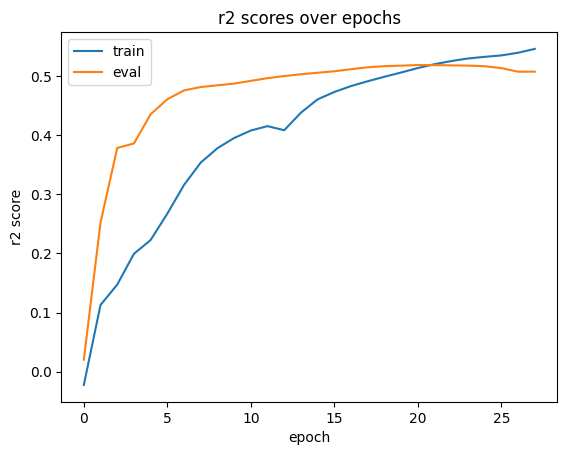

In [32]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()

In [32]:
# smoothed model
loss, epoch_r2_score = evaluate(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 1.8422
Eval R2: 0.5511


In [32]:
# unsmoothed model
loss, epoch_r2_score = evaluate(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 3.4521
Eval R2: 0.1688


In [42]:
# To Do: 
# Build function to evaluate individual areas - Done
# Sort all years in an year by return - Done
# Display all relevant graphs for an year
# Make model loadable from a file

In [98]:
def predict_return(model, area_code, year):
    area_df = df[(df["year"] == year) & (df["area_code"] == area_code)]

    area_dataset = JapanRETimeSeriesDataset(
        df,
        area_df,
        feature_columns=feature_columns,
        metrics=[normalized_metric_pct_chg],
        transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    )

    area_dataloader = DataLoader(
        area_dataset, batch_size=10, shuffle=False, num_workers=0
    )

    batch = next(iter(area_dataloader))
    
    model.eval()

    output = model(batch["window"].to(device), batch["mask"].to(device))
    return output.item()

In [141]:
df = df
tokyo_df = df[(df["area_code"].astype(int) // 1000 == 13)]

In [178]:
years = [2020, 2021, 2022] # saving all predicted years.
year = 2022 # saving all predicted years.

prediction_df = df
prediction_df = prediction_df[prediction_df["year"] == year]
prediction_df["predicted_normalized_return"] = prediction_df.apply(
    lambda row: predict_return(model, row["area_code"], row["year"]), axis=1
)
prediction_df = prediction_df.sort_values(
    by="predicted_normalized_return", ascending=False
)
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
]

,year,area_code,predicted_normalized_return,unit_price_wmedian_smoothed_pct_chg,normalized_unit_price_wmedian_smoothed_pct_chg
19721,2022,42321,2.998061,1.173793,3.298454
20587,2022,29386,2.924232,-0.042226,-0.296605
19506,2022,34545,2.917858,0.343532,0.843857
20548,2022,5202,2.875193,0.541023,1.427722
19919,2022,36468,2.862989,1.193531,3.356809
...,...,...,...,...,...
20153,2022,10523,-1.614255,-0.549190,-1.795401
20424,2022,28585,-1.616984,-0.374725,-1.279611
19396,2022,20309,-1.650744,-0.475046,-1.576201
19618,2022,4424,-1.714330,-0.349202,-1.204154


In [185]:
prediction_df[["year", "area_code", "predicted_normalized_return"]].to_csv(model_output_data_path, index=False)

In [184]:
model_ready_data_path

'../../data/model_ready/sequence_transactions_weighted_median_smoothed_2.csv'

In [164]:
columns
factors = [
    # "unit_price_wmedian_smoothed",
    "return_growth",
    "taxable_income",
    "total_tax",
    "taxpayer_count",
    "taxable_income_per_taxpayer",
    "existing_dwellings",
    "population",
    "count",
]

In [165]:
# Notes: 
# 1. Use frontfill before smoothing to improve data quality and prevent return calculation from being affected by missing data

In [171]:
area_codes = [13108, 13305]
area_df = df[df["area_code"].isin(area_codes)].sort_values(by="year", ascending=True)
area_df["return_growth"] = get_cumulative_growth(
    area_df.copy(), metric_pct_chg
)

for factor in factors:
    plot_time_series(
        area_df.replace(0, np.nan),
        factor,
        ["area_code", "year"],
        ["area"],
        f"{factor} over time",
        # visible="legendonly",
        width=1000,
        height=400,
    )